**1. Setup and Get Data**

1.1 Install Dependencies and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow opencv-python matplotlib

1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2  #for image recognotion
import os    #for path
import random
import numpy as np  #array tranformation library
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
#model(input=input image, verification image, output=[1,0])

from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
#Layer->define a custom layer(neural network)
#conv2d->convolutional neural network
#dense->gives fully connected layer
#maxpooling->shirnks the information
#Input->define what we are passing throuth the layer input(shape=)
#flatten->takes all the infor from previous layer and platten its down in single layer
import tensorflow as tf
#for image processing


**1.3 Set GPU Growth**

In [4]:
#Avoid  OOM error(OUT OF MEMORY) by seting GPU memory Consumption Growth
gpus=tf.config.experimental.list_physical_devices('GPU')  #all gpus present
for gpu in gpus:  #looping through all of them
  tf.config.experimental.set_memory_growth(gpu,True)


In [5]:
len(gpus) #length pf gpu

1

**1.4 Create Folder Structures**

In [6]:
data='/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data'

In [7]:
# Setup paths
POS_PATH = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/positive'
NEG_PATH = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/negative'
ANC_PATH = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/anchor'

**2. Collect Positives and Anchors**

2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/lfw'):
    for file in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/lfw', directory)):
        EX_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


FileNotFoundError: ignored

2.2 Collect Positive and Anchor Classes

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/anchor/457aba14-8b78-11ee-b18e-0242ac1c000c.jpg'

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import uuid

# Create directories to save images
ANC_PATH = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/anchor'
POS_PATH = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/positive'

# Set the desired frame size
frame_width = 250
frame_height = 250

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(frame_width, frame_height, quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            video.width = frame_width;
            video.height = frame_height;
            const stream = await navigator.mediaDevices.getUserMedia({video: {width: frame_width, height: frame_height}});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            canvas.width = frame_width;
            canvas.height = frame_height;

            function capture() {
                canvas.getContext('2d').drawImage(video, 0, 0, frame_width, frame_height);
                stream.getVideoTracks()[0].stop();
                div.remove();

                return canvas.toDataURL('image/jpeg', quality);
            }

            // Wait for 'c' key press to capture
            return new Promise((resolve) => {
                document.addEventListener('keydown', function(e) {
                    if (e.key === 'c') {
                        resolve(capture());
                    }
                });
            });
        }
    ''')
    display(js)
    data = eval_js('takePhoto({}, {}, {})'.format(frame_width, frame_height, quality))
    if data is not None:
        binary = b64decode(data.split(',')[1])
        return cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)
    else:
        return None

# Create directories if they don't exist
os.makedirs(ANC_PATH, exist_ok=True)
os.makedirs(POS_PATH, exist_ok=True)

# Number of pictures to capture
num_pictures = 300

# Capture and save pictures
for i in range(num_pictures):
    image = take_photo()

    if image is not None:
        # Create unique file paths
        imgname_anchor = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        imgname_positive = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))

        # Write out the captured image to both paths
        cv2.imwrite(imgname_anchor, image)
        cv2.imwrite(imgname_positive, image)

    # No acknowledgment messages

print("Capture process completed.")


2.x NEW - Data Augmentation

**3. Load and Preprocess Images**

**3.1 Get Image Directories**

In [8]:
#list_files->get all images in director created a generator and loop through to get all the img
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)


In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
print(dir_test.next())

b'/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/anchor/d876435c-89e7-11ee-8611-0242ac1c000c.jpg'


3.2 Preprocessing - Scale and Resize

In [11]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [12]:
img = preprocess('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/data/anchor/00c170ea-89e6-11ee-8611-0242ac1c000c.jpg')

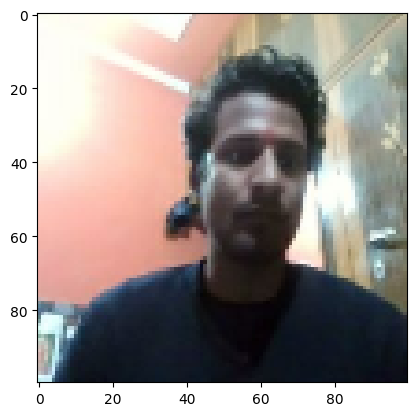

In [13]:
plt.imshow(img)

3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1   ->positive class
# (anchor, negative) => 0,0,0,0,0   ->negative class

In [14]:
tf.ones_like([1,1,1,3.434535,5.5337,4.77])

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1.], dtype=float32)>

In [15]:
#creating labled data set
#here we have concatinated everything into one  under data((anchor),(positive/negative),(1/0))
#zip->zip all together
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

**3.4 Build Train and Test Partition**

In [16]:
#function to pre process twin
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()  #->caching the info
data = data.shuffle(buffer_size=100000)  #->suffling everything

In [18]:
# Training partition->70%
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
#start pre processing of next set of data while processing

In [19]:
batch=train_data.as_numpy_iterator()

In [20]:
print(batch.next())

(array([[[[1.00000000e+00, 1.00000000e+00, 9.68627453e-01],
         [1.00000000e+00, 1.00000000e+00, 9.68627453e-01],
         [1.00000000e+00, 1.00000000e+00, 9.68627453e-01],
         ...,
         [3.81127447e-01, 3.79166663e-01, 2.80147046e-01],
         [3.75490189e-01, 3.58823538e-01, 2.77450979e-01],
         [3.84313732e-01, 3.56862754e-01, 2.86274523e-01]],

        [[1.00000000e+00, 1.00000000e+00, 9.66666639e-01],
         [1.00000000e+00, 1.00000000e+00, 9.66666639e-01],
         [1.00000000e+00, 1.00000000e+00, 9.66666639e-01],
         ...,
         [3.76470596e-01, 3.74509811e-01, 2.77450979e-01],
         [3.76715690e-01, 3.57843131e-01, 2.77941167e-01],
         [3.87254894e-01, 3.59803915e-01, 2.89215684e-01]],

        [[1.00000000e+00, 1.00000000e+00, 9.60784316e-01],
         [1.00000000e+00, 1.00000000e+00, 9.60784316e-01],
         [1.00000000e+00, 1.00000000e+00, 9.60784316e-01],
         ...,
         [3.74509811e-01, 3.63725483e-01, 2.80882359e-01],
         

In [21]:
# Testing partition->30%
test_data = data.skip(round(len(data)*.7)) #->training part
test_data = test_data.take(round(len(data)*.3)) #->testing part
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**4. Model Engineering**

**4.1 Build Embedding Layer**

In [22]:
inp = Input(shape=(100,100,3), name='input_image')
#->Input layer

In [23]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
#->64 filters each 10 by 10 pixals(how far pixles move) with relu activation


In [24]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
#-> 64 filter with 2X2 pixal padding same to replicate same output shape

In [25]:
#block 1
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
#block 2
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [26]:
#final embedding
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [27]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [28]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [29]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

    #->two stream of data now its distance will be calculated

In [30]:
embedding = make_embedding()

In [31]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

**4.2 Build Distance Layer**

In [32]:
# Siamese L1 Distance class
#comparison will be done by subtracting two streams that is how we will find
# how similar they are that is siamese distance layer
class L1Dist(Layer): #Layer class(base class->keras layer) provide templat for layer

    # Init method - inheritance
    def __init__(self, **kwargs):#->**kwargs->helps to work with this specific layer export import is simple with this
        super().__init__()

    # Magic happens here - similarity calculation->what to do??
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)#->absolute of difference

In [33]:
l1 = L1Dist()

**4.3 Make Siamese Model**

In [34]:
#defining two inputs
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [35]:
#raw input to convert into embedding then it will be combied with distance layer
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [36]:
siamese_layer = L1Dist()

In [37]:
#calculation distance layer
distances = siamese_layer(inp_embedding, val_embedding)

In [38]:
#classify them like cheking do these embedding look similar
classifier = Dense(1, activation='sigmoid')(distances)
#->1 unit (1/0) as output

In [39]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [40]:
#connecting everything together
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [41]:
siamese_network.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [42]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [43]:
siamese_model = make_siamese_model()

In [44]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

**5. Training**

**5.1 Setup Loss and Optimizer**

In [45]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
#

In [46]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001 <-learing rate


**5.2 Establish Checkpoints**

In [47]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
#optimiser and model is saved

**5.3 Build Train Step Function**

In [48]:
test_batch = train_data.as_numpy_iterator()

In [49]:
batch_1 = test_batch.next()

In [50]:
X = batch_1[:2]

In [51]:
len(batch_1)

3

In [52]:
len(batch_1[0])

16

In [53]:
y = batch_1[2]

In [54]:
y

array([1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [55]:
@tf.function  #->compiles a function as callable tensorflow graph(funtion decorator)
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape: #->record operation for automatic differentiation
        # Get anchor and positive/negative image
        X = batch[:2] #->slicing the 2 values
        # Get label
        y = batch[2]

        # Forward pass
        #yhat->name for predicted outcome
        yhat = siamese_model(X, training=True) #->certain layers activate only when traing is true
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

**5.4 Build Training Loop**

In [56]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [57]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints at every 10th epoch
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

**5.5 Train the model**

In [58]:
EPOCHS = 100

In [59]:
train(train_data, EPOCHS)


 Epoch 1/100
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
33/33 [==============================] - 35s 371ms/step
0.13325278 0.9055118 0.8984375

 Epoch 2/100
33/33 [==============================] - 11s 329ms/step
0.0023488416 0.9586466 0.98455596

 Epoch 3/100
33/33 [==============================] - 10s 319ms/step
0.11808659 0.9522059 0.99615383

 Epoch 4/100
33/33 [==============================] - 10s 317ms/step
0.15239096 0.972973 1.0

 Epoch 5/100
33/33 [==============================] - 11s 322ms/step
0.052453272 0.9737828 1.0

 Epoch 6/100
33/33 [==============================] - 11s 331ms/step
0.13849369 0.98062015 1.0

 Epoch 7/100
33/33 [==============================] - 10s 314ms/step
0.013502945 0.99630994 1.0

 Epoch 8/100
33/33 [==============================] - 11s 326ms/step
0.049042527 0.99250937 1.0

 Epoch 9/100
33/33 [==============================] - 11s 

**6. Evaluate Model**

**6.1 Import Metrics**

In [60]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
#->tells how accurate and how well its performing....

**6.2 Make Predictions**

In [61]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [62]:
y_hat = siamese_model.predict([test_input, test_val])


1/1 [==============================] - 0s 36ms/step


In [63]:
y_hat

array([[2.8232900e-11],
       [1.8340558e-10],
       [1.1084204e-11],
       [1.4008321e-08],
       [7.1629421e-13],
       [8.3724633e-12],
       [1.5910691e-09],
       [1.7160119e-07],
       [2.9341564e-11],
       [1.0000000e+00],
       [5.3345672e-11],
       [9.9996150e-01],
       [2.3826031e-07],
       [9.9999762e-01],
       [1.8883533e-09],
       [5.8859877e-09]], dtype=float32)

In [64]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]

In [65]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

**6.3 Calculate Metrics**

In [66]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [67]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [68]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 225ms/step
1.0 1.0


**6.4 Viz Results**

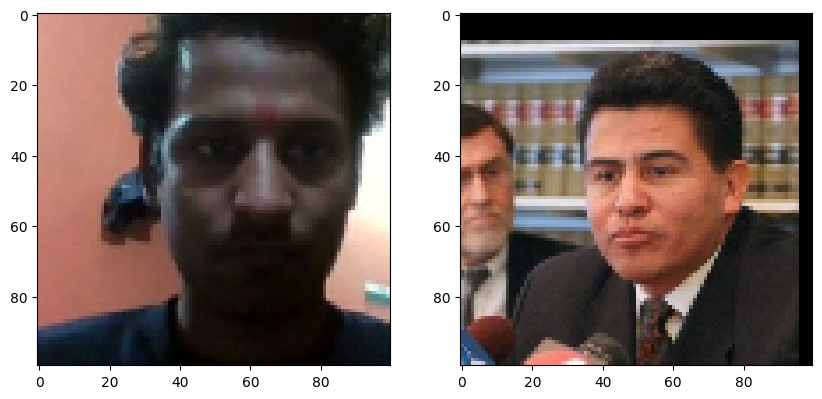

In [69]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1) #->row,col,index
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

**7. Save Model**

In [70]:
# Save weights
siamese_model.save('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/siamesemodelv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
L1Dist

__main__.L1Dist

In [72]:
# Reload model
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [73]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 109ms/step


array([[1.2332395e-11]], dtype=float32)

In [74]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

**8. Real Time Test**

**8.1 Verification function**

In [75]:
os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data', 'verification_images'))

['Copy of fd739bb2-89e4-11ee-8611-0242ac1c000c.jpg',
 'Copy of ff553cb0-89e4-11ee-8611-0242ac1c000c.jpg',
 'Copy of ffa1f45a-8b84-11ee-bafd-0242ac1c000c.jpg',
 'Copy of fe58ab62-89e4-11ee-8611-0242ac1c000c.jpg',
 'Copy of fbc7e2be-89e4-11ee-8611-0242ac1c000c.jpg',
 'Copy of fe7f971c-8b84-11ee-bafd-0242ac1c000c.jpg',
 'Copy of fd20eefc-8b84-11ee-bafd-0242ac1c000c.jpg',
 'Copy of fc11ff24-8b84-11ee-bafd-0242ac1c000c.jpg',
 'Copy of fca942b8-89e4-11ee-8611-0242ac1c000c.jpg',
 'Copy of facf7368-89e4-11ee-8611-0242ac1c000c.jpg',
 'Copy of faa30f66-8b84-11ee-bafd-0242ac1c000c (1).jpg',
 'Copy of f06853d0-8b84-11ee-bafd-0242ac1c000c (1).jpg',
 'Copy of f5046d5a-89e7-11ee-8611-0242ac1c000c (1).jpg',
 'Copy of f5376158-8b84-11ee-bafd-0242ac1c000c (1).jpg',
 'Copy of f5902b86-89e4-11ee-8611-0242ac1c000c (1).jpg',
 'Copy of f7377944-89e4-11ee-8611-0242ac1c000c (1).jpg',
 'Copy of f665843e-89e4-11ee-8611-0242ac1c000c (1).jpg',
 'Copy of f3105932-89e7-11ee-8611-0242ac1c000c (1).jpg',
 'Copy of f022

In [76]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [77]:
for image in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/Copy of fd739bb2-89e4-11ee-8611-0242ac1c000c.jpg
application_data/verification_images/Copy of ff553cb0-89e4-11ee-8611-0242ac1c000c.jpg
application_data/verification_images/Copy of ffa1f45a-8b84-11ee-bafd-0242ac1c000c.jpg
application_data/verification_images/Copy of fe58ab62-89e4-11ee-8611-0242ac1c000c.jpg
application_data/verification_images/Copy of fbc7e2be-89e4-11ee-8611-0242ac1c000c.jpg
application_data/verification_images/Copy of fe7f971c-8b84-11ee-bafd-0242ac1c000c.jpg
application_data/verification_images/Copy of fd20eefc-8b84-11ee-bafd-0242ac1c000c.jpg
application_data/verification_images/Copy of fc11ff24-8b84-11ee-bafd-0242ac1c000c.jpg
application_data/verification_images/Copy of fca942b8-89e4-11ee-8611-0242ac1c000c.jpg
application_data/verification_images/Copy of facf7368-89e4-11ee-8611-0242ac1c000c.jpg
application_data/verification_images/Copy of faa30f66-8b84-11ee-bafd-0242ac1c000c (1).jpg
application_data/verification_images/Copy of f0685

In [78]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

<IPython.core.display.Javascript object>

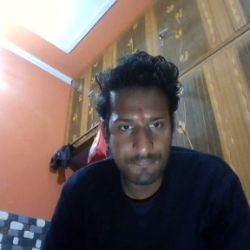

1/1 [==============================] - 0s 29ms/step
True
Verification triggered.


<IPython.core.display.Javascript object>

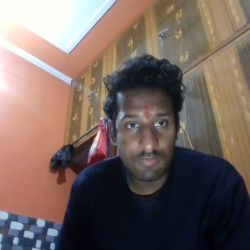

1/1 [==============================] - 0s 31ms/step
True
Verification triggered.


<IPython.core.display.Javascript object>

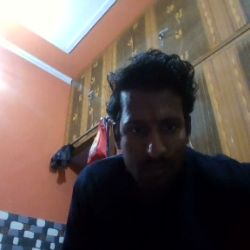

1/1 [==============================] - 0s 37ms/step
True
Verification triggered.


<IPython.core.display.Javascript object>

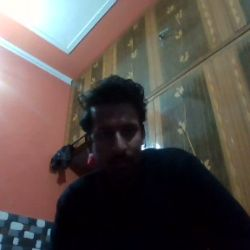

1/1 [==============================] - 0s 28ms/step
True
Verification triggered.


<IPython.core.display.Javascript object>

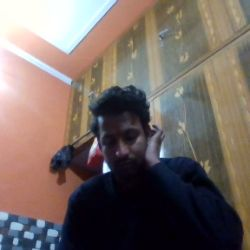

1/1 [==============================] - 0s 18ms/step
True
Verification triggered.
Capture process completed.


In [79]:
import os
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import uuid
import cv2

# Set the desired frame size
frame_width = 250
frame_height = 250

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(frame_width, frame_height, quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            video.width = frame_width;
            video.height = frame_height;
            const stream = await navigator.mediaDevices.getUserMedia({video: {width: frame_width, height: frame_height}});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            canvas.width = frame_width;
            canvas.height = frame_height;

            function capture() {
                canvas.getContext('2d').drawImage(video, 0, 0, frame_width, frame_height);
                stream.getVideoTracks()[0].stop();
                div.remove();

                return canvas.toDataURL('image/jpeg', quality);
            }

            // Wait for 'c' key press to capture
            return new Promise((resolve) => {
                document.addEventListener('keydown', function(e) {
                    if (e.key === 'c') {
                        resolve(capture());
                    }
                });
            });
        }
    ''')
    display(js)
    data = eval_js('takePhoto({}, {}, {})'.format(frame_width, frame_height, quality))
    if data is not None:
        binary = b64decode(data.split(',')[1])
        return cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)
    else:
        return None

# Set the correct application path
application_path = '/content/drive/MyDrive/Colab Notebooks/FaceRecognition/application_data'

# Create directories if they don't exist
os.makedirs(os.path.join(application_path, 'input_image'), exist_ok=True)

# Number of pictures to capture
num_pictures = 5

# Capture and save pictures
for i in range(num_pictures):
    image = take_photo()

    if image is not None:
        # Display the captured image
        cv2_imshow(image)

        # Save input image to application_data/input_image folder
        input_image_path = os.path.join(application_path, 'input_image', 'input_image.jpg')
        cv2.imwrite(input_image_path, image)

        # Run verification (replace this with your actual verification function)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
        print("Verification triggered.")

print("Capture process completed.")


In [80]:
np.sum(np.squeeze(results) > 0.9)

48